# Deep Residual Networks (Resnet)

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385

https://arxiv.org/pdf/1512.03385.pdf

CNN 이 이미지 인식 분야에서 뛰어난 성능을 보여주며, 네트워크의 layer를 깊이 쌓으며 성능 향상을 이루고 있었습니다. 하지만, 실제로 layer를 깊게 쌓게 되면 gradient vanishing 문제가 생겨 성능이 더 떨어지는데 layer가 깊어지면서 역전파로 얻어지는 기울기가 너무 작거나 커지면서 문제가 생기게 되는겁니다.

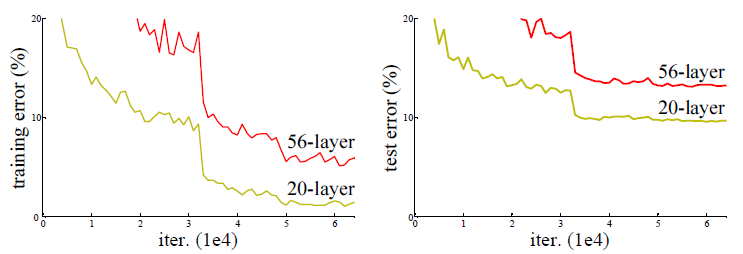

더 깊은 친구가 더 좋은 성능을 내기위한 deep residual learning (ResNet) 이 제안 되었습니다. 위에서 말한 문제를 해결하기 위해 Residual Learning 방법이 사용 되었습니다.

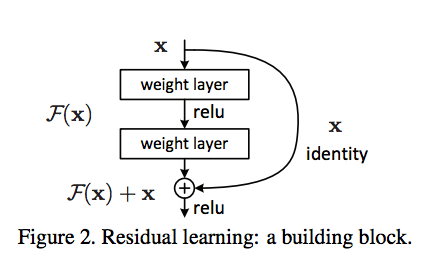

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os

In [2]:
from torchsummary import summary

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # VGG의 철학을 따라 3 x 3 filter 사용
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 마찬가지로 3 x 3 filter 사용, 2번째 conv layer에서는 차원이 변하지 않음
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)


        ######################## ResNet의 핵심 부분 ######################################
        #
        # Mapping을 추가해 주어야 하는데, dimension이 변하는 부분을 고려해야 함.
        # (ResNet에서는 complexity를 유지하기 위해서 dimension이 변하는 경우에만 stride = 2로 변경)
        #
        # 1. stride == 1인 경우 : dimension이 변하지 않음 -> identity mapping 사용
        # 2. stride != 1인 경우 : dimension이 변하는 경우이므로 identity mapping을 사용할 수 없음
        #                        -> 1 x 1 convolution을 활용하여 차원을 맞추어 줌.
        #

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        # 실제 논문에서 사용한 방식과 거의 유사함 (shortcut 위치 등)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [4]:
#Optional
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleNeck, self).__init__()

        # Convolutional and Batch Normalization Layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = stride, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               padding = 1, stride = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv3d(out_channels, out_channels * self.expansion,
                               kernel_size = 1, stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        # Shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                          kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [5]:
# Basic Block을 여러 개 붙여서 ResNet을 정의
# 앞서 정의한 Basic Block을 _make_layer() method에 넘겨서 이어붙이는 구조
# num_blocks에 [2, 2, 2, 2]를 넘겨주면 18-layer가 됨 (conv1 + 4 + 4 + 4 + 4 + FC)

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=20, init_weights=True):
        # block: ResidualBlock or Bottleneck
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)


    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 첫 번째 conv에서만 stride를 통해 차원을 변경해줄 수 있도록 지정
        # num_blocks = 3이라고 하면 building block 3개를 이어붙이므로 6개의 layer가 생기는 것
        # (단, 1번째 block의 conv1에만 stride를 적용하고 나머지는 1)
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)  # FC 레이어
        return x

전체 구조

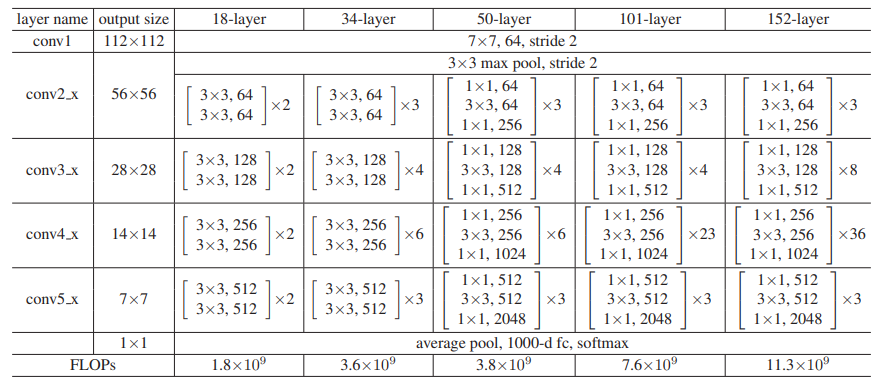

18, 34 layer는 Basicblock을 사용하고, 나머지는 Bottleneck block 을 사용합니다.

In [6]:
def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    #TODO (pass를 지우고 맞는 numblocks 넘겨주어 34-layer ResNet구현)
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    #TODO (pass를 지우고 맞는 numblocks 넘겨주어 50-layer ResNet구현, hint:BottleNeck 사용)
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    #TODO (pass를 지우고 맞는 numblocks 넘겨주어 101-layer ResNet구현)
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    #TODO (pass를 지우고 맞는 numblocks 넘겨주어 152-layer ResNet구현)
    return ResNet(BottleNeck, [3, 8, 36, 3])


CIFAR10 데이터:

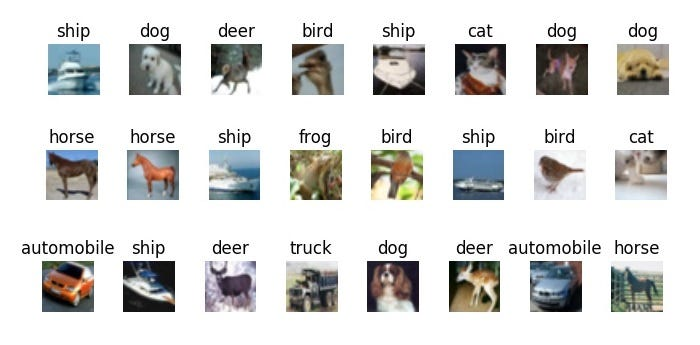

In [7]:
# CIFAR10

import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = resnet34() #다른 layer로 수정
net = net.to(device)
net = torch.nn.DataParallel(net)

learning_rate = 0.1
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

In [9]:

def train(epoch):
    print("------------------------------------------------------------")
    print('\nEpoch %d (train)' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print('\nBatch', str(batch_idx))
            print('Accuracy (train):', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Loss:', loss.item())

    print('\nTotal accuarcy (train):', 100. * correct / total)
    print('Total loss:', train_loss)


def test(epoch):
    print('\nEpoch: %d (test)' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nAccuracy (test):', 100. * correct / total)
    print('Test average loss:', loss / total)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
# for epoch in range(0, 200):
for epoch in range(0, 2):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)

------------------------------------------------------------

Epoch 0 (train)



Batch 0
Accuracy (train): 0.046875
Loss: 3.6677916049957275

Batch 100
Accuracy (train): 0.1328125
Loss: 2.5177102088928223

Batch 200
Accuracy (train): 0.234375
Loss: 2.4809460639953613

Batch 300
Accuracy (train): 0.2109375
Loss: 2.256998062133789

Total accuarcy (train): 16.38
Total loss: 1005.9139777421951

Epoch: 0 (test)

Accuracy (test): 21.71
Test average loss: 0.022069517827033997
Model Saved!
------------------------------------------------------------

Epoch 1 (train)

Batch 0
Accuracy (train): 0.265625
Loss: 2.040787935256958

Batch 100
Accuracy (train): 0.171875
Loss: 1.9172905683517456

Batch 200
Accuracy (train): 0.2265625
Loss: 1.9668478965759277

Batch 300
Accuracy (train): 0.265625
Loss: 1.9442739486694336

Total accuarcy (train): 24.522
Total loss: 765.7483321428299

Epoch: 1 (test)

Accuracy (test): 30.06
Test average loss: 0.0187895259141922
Model Saved!


## Assignment

1. 18-layer의 ResNet을 구현한 코드의 구조를 활용하거나, 필요하다면 새로운 코드를 추가하여 다른 layer의 ResNet을 구현해 보세요. 돌리는데 시간이 오래 걸릴 수 있으니 학습이 되는지만 확인하고 끝까지 training 진행하지 않아도 됩니다.(resnet def은 모든 레이어에 대해서 해주고, 돌리는 것만 하나 정해서 진행)

2. ResNet은 점점 더 깊은 모델을 만드는 과정에서 생긴 문제점을 해결하기 위해서 나온 모델입니다. 그렇다면 더 깊게 layer를 쌓았을 때 일반적으로 성능 관점에서 기대할 수 있는 장점이 무엇인지 서술해 보세요.
* 논문에서 34-layer ResNet과 18-layer ResNet의 차이점을 비교하였다. 첫 번째, 34-layer ResNet이 상대적으로 낮은 training error를 가지며 validation dataset에 더 잘 generalize할 수 있다. 18-layer ResNet은 27.88%의 Top-1 error를 갖는 방면 34-layer ResNet은 25.03%의 Top-1 error로 더 낮은 에러를 갖는다. 하지만 그렇다고 무작정 layer의 수를 늘린다고 좋은 성능을 내는 것은 아니다. 110-layer ResNet은 6.43%의 에러를 갖는 방면에 1202-layer ResNet은 7.93%로 더 높은 에러를 갖는다. 그 이유는 parameter의 개수가 커져 생기는 overfitting 때문이다. 이런 문제를 해결하여 성능을 높이기 위해서는 dropout이나 maxout와 같은 regularization을 추가하는 것이 될 것이다.

3. ResNet의 주요 아이디어 중 하나는 어떤 형태의 블록을 사용하는 것인가요? 그 블록의 구조를 설명하세요.
* ResNet에서 사용되는 building block에서 가장 중요한 것은 바로 'identity mapping'이다. Networks가 점점 깊어질수록 (layer가 많아질수록) degradation 문제가 발생하는데 F(x)+x의 residual mapping을 소개함으로써 optimize를 더 잘 시킬 수 있다.

4. **[Optional]** 위의 코드에서는 2개의 convolution layer와 identity mapping layer를 묶어서 하나의 BasicBlock을 만들고, 이를 여러 개 쌓아서 18-layer의 ResNet을 구현하였습니다. 그러나 50-layer 이상으로 ResNet이 깊어지면 parameter의 수가 많아지기 때문에 BasicBlock 대신 **Bottleneck Block** 을 이용하게 됩니다. 아래의 그림을 참고하여 Bottleneck block class를 새로 정의하고, 이를 _make_layer() 함수에 넘겨주는 방식으로 50-layer의 ResNet을 구현해 보세요. (그림 왼쪽이 BasicBlock, 오른쪽이 BottleNeck Block)

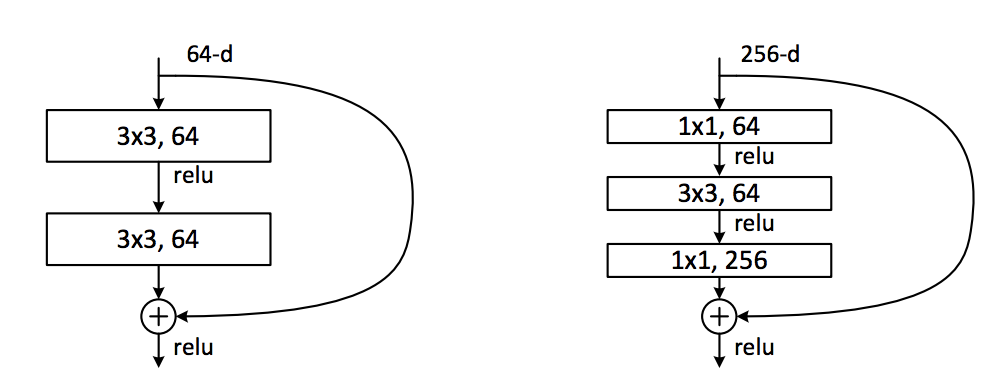

제출 기한: 1월 25일 목요일까지